In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

data_dir = "./data"
device = torch.device("cpu")

print(f"Data resides in        : {data_dir}")
print(f"Training model on      : {str(device)}")

Data resides in        : ./data
Training model on      : cpu


Using downloaded and verified file: ./data/MNIST/raw/train-images-idx3-ubyte.gz
Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Using downloaded and verified file: ./data/MNIST/raw/train-labels-idx1-ubyte.gz
Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



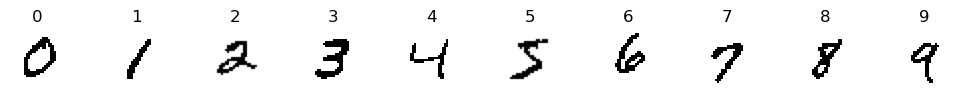

In [2]:
def print_samples(samples, elements_per_row=10, fig_width=10, cmap="binary"):
    num_digits = len(samples)
    num_rows = (num_digits + elements_per_row - 1) // elements_per_row

    plt.figure(figsize=(fig_width, fig_width / elements_per_row * num_rows))
    for idx, (label, image) in enumerate(samples):
        plt.subplot(num_rows, elements_per_row, idx + 1)
        plt.imshow(image.squeeze(), cmap=cmap)
        plt.title(label, fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0,), (1,)),               # normalize to [0, 1]
    transforms.Lambda(lambda x: (x > 0.5).float())  # binarize
])

train_dataset = datasets.MNIST(root=data_dir, train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root=data_dir, train=False, download=True, transform=transform)

sample_list = [(label, next(image for image, lbl in train_dataset if lbl == label)) for label in range(10)]
print_samples(sample_list)

In [3]:
class RBM(nn.Module):
    def __init__(self, n_visible, n_hidden):
        super().__init__()
        self.n_visible = n_visible
        self.n_hidden = n_hidden

        self.W = nn.Parameter(torch.randn(n_visible, n_hidden) * 0.01)
        self.b = nn.Parameter(torch.zeros(n_visible))
        self.c = nn.Parameter(torch.zeros(n_hidden))

    def _sample_hidden(self, v, T=1.0):
        logits = (v @ self.W + self.c) / T
        h_probs = torch.sigmoid(logits)
        h_sample = torch.bernoulli(h_probs)
        return h_sample, h_probs

    def _sample_visible(self, h, T=1.0):
        logits = (h @ self.W.t() + self.b) / T
        v_probs = torch.sigmoid(logits)
        v_sample = torch.bernoulli(v_probs)
        return v_sample, v_probs

    def sample_gibbs(self, v0_sample, k=1, T=1.0):
        v = v0_sample
        for _ in range(k):
            h, _ = self._sample_hidden(v, T)
            v, _ = self._sample_visible(h, T)
        return v

    def free_energy(self, v):
        visible_term = v @ self.b
        hidden_term = nn.functional.softplus(v @ self.W + self.c).sum(dim=1)
        return -visible_term - hidden_term

    def generate(self, n_samples=16, T_schedule=None):
        self.eval()
        v = torch.bernoulli(torch.rand(n_samples, self.n_visible)).to(self.W.device)

        with torch.no_grad():
            for T in T_schedule:
                v = self.sample_gibbs(v, k=1, T=T)

        return v.cpu()

In [4]:
def train_rbm(rbm, train_loader, num_epochs, k, optimizer, scheduler=None, pcd_reset=5):
    rbm.train()

    fantasy_particles = torch.bernoulli(torch.rand(batch_size, rbm.n_visible)).to(device)

    metrics = {}
    for epoch in range(num_epochs):
        total_loss = 0.0

        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.view(-1, rbm.n_visible).to(device)

            if batch_idx % pcd_reset == 0:
                fantasy_particles = torch.bernoulli(torch.rand(batch_size, rbm.n_visible)).to(device)

            v_k = rbm.sample_gibbs(fantasy_particles, k)
            fantasy_particles = v_k.detach()

            loss = rbm.free_energy(data).mean() - rbm.free_energy(v_k).mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        if scheduler is not None:
            scheduler.step()

        avg_loss = total_loss / len(train_loader)
        metrics[epoch] = { "free_energy_loss": avg_loss }
        print(f"Epoch [{epoch+1}/{num_epochs}] - Free Energy Loss: {avg_loss:.4f}")

    return metrics


#### TRAINING

batch_size      = 128
visible_units   = 28*28
hidden_units    = 256
k               = 1
lr              = 1e-3
num_epochs      = 40
pcd_reset       = 75        # reset persistent chain every N batches
weight_decay    = 1e-5      # L2 regularization
lr_decay        = 0.95      # learning rate decay PER EPOCH


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

rbm = RBM(visible_units, hidden_units).to(device)

optimizer = optim.Adam(rbm.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=lr_decay)

metrics = train_rbm(rbm, train_loader, num_epochs=num_epochs, k=k, optimizer=optimizer, scheduler=scheduler, pcd_reset=pcd_reset)

Epoch [1/40] - Free Energy Loss: -83.7398
Epoch [2/40] - Free Energy Loss: -154.6937
Epoch [3/40] - Free Energy Loss: -218.9986
Epoch [4/40] - Free Energy Loss: -213.6369
Epoch [5/40] - Free Energy Loss: -196.6386
Epoch [6/40] - Free Energy Loss: -165.1392
Epoch [7/40] - Free Energy Loss: -119.0139
Epoch [8/40] - Free Energy Loss: -102.5185
Epoch [9/40] - Free Energy Loss: -76.5279
Epoch [10/40] - Free Energy Loss: -70.2681
Epoch [11/40] - Free Energy Loss: -68.0853
Epoch [12/40] - Free Energy Loss: -65.6964
Epoch [13/40] - Free Energy Loss: -67.8564
Epoch [14/40] - Free Energy Loss: -58.6586
Epoch [15/40] - Free Energy Loss: -57.8765
Epoch [16/40] - Free Energy Loss: -59.3696
Epoch [17/40] - Free Energy Loss: -57.2101
Epoch [18/40] - Free Energy Loss: -53.1131
Epoch [19/40] - Free Energy Loss: -53.3037
Epoch [20/40] - Free Energy Loss: -48.2051
Epoch [21/40] - Free Energy Loss: -48.8131
Epoch [22/40] - Free Energy Loss: -47.4368
Epoch [23/40] - Free Energy Loss: -46.1120
Epoch [24/40]

Text(0, 0.5, 'Free Energy Loss')

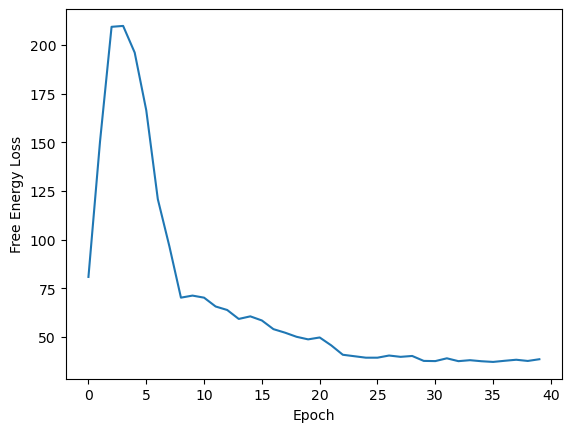

In [83]:
plt.plot([abs(metrics[epoch]['free_energy_loss']) for epoch in metrics])
plt.xlabel("Epoch")
plt.ylabel("Free Energy Loss")

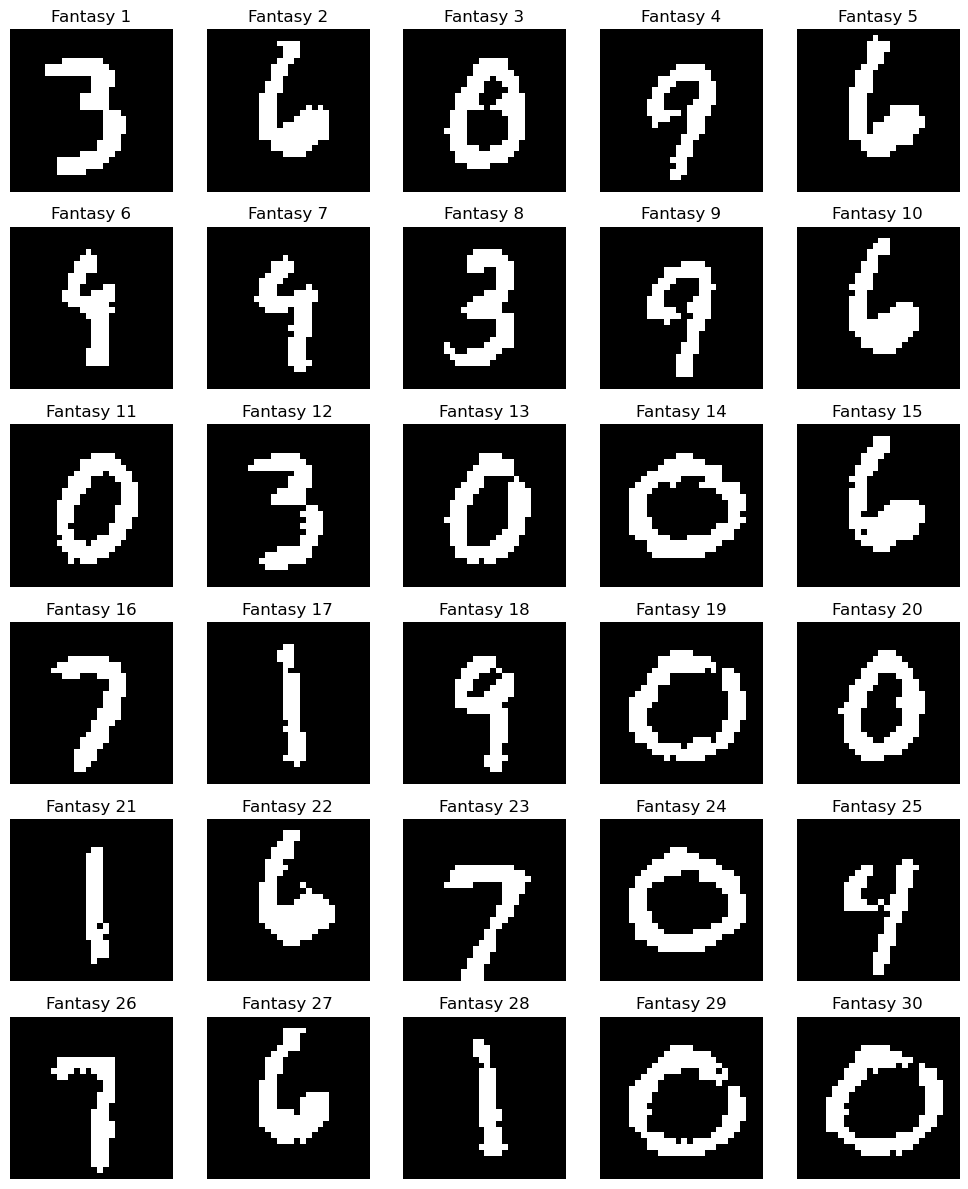

In [5]:
class CosineAnnealer:
    def __init__(self, T_high, T_low, n_steps):
        steps = torch.arange(n_steps, dtype=torch.float32)
        cos = 0.5 * (1 + torch.cos(torch.pi * steps / (n_steps - 1)))
        self.schedule = T_low + (T_high - T_low) * cos

    def __getitem__(self, idx):
        return self.schedule[idx]

    def __len__(self):
        return len(self.schedule)

    def get_schedule(self):
        return self.schedule


annealer = CosineAnnealer(4.0, 0.4, 1000)
samples = rbm.generate(n_samples=30, T_schedule=annealer.get_schedule()).view(-1, 1, 28, 28)

labeled_samples = [(f"Fantasy {idx + 1}", img) for idx, img in enumerate(samples)]
print_samples(labeled_samples, elements_per_row=5, fig_width=10, cmap="gray")